In [1]:
# Configure task - change this to any available task
TASK_NAME = 'SO100HandOverBanana'  # Options: 'SO100HandOverBanana', 'SO100HandOverApple', etc.

import sys
import os

from scripts.so101_lerobot_wrapper import SO101LeRobotWrapper
import numpy as np
import time
from scripts.image_utils import display_images, tensor_to_pil

In [2]:
def plot_images(obs):
    img_overhead = tensor_to_pil(obs['observation.images.overhead_cam'])
    img_front = tensor_to_pil(obs['observation.images.front_cam'])
    img_wrist = tensor_to_pil(obs['observation.images.wrist_cam'])

    # Display all camera views
    display_images(img_overhead, img_front, img_wrist)

   Cameras: ('overhead_cam', 'front_cam', 'wrist_cam')
   Resolution: (480, 640)
   Device: cpu


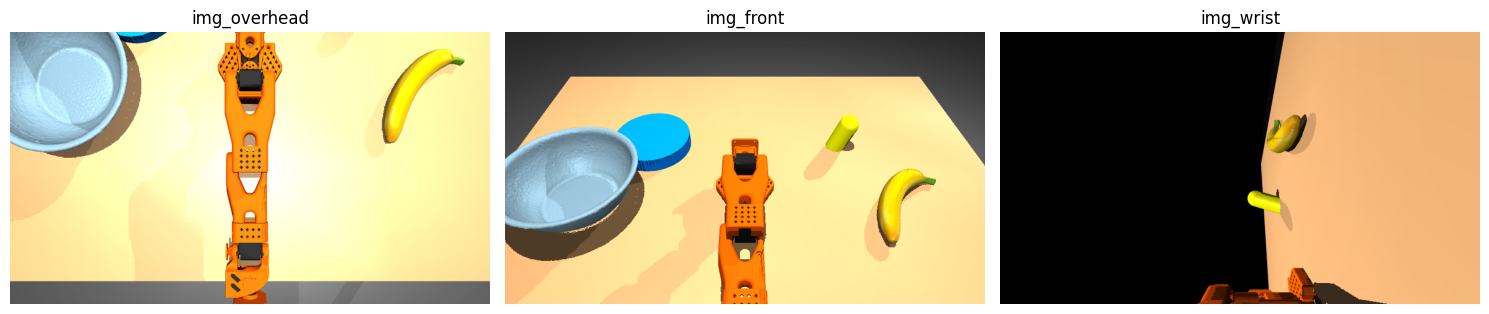

In [3]:
# Create environment with real robot
cameras = ('overhead_cam', 'front_cam', 'wrist_cam')
lerobot = SO101LeRobotWrapper(
    task_name=TASK_NAME,
    cameras=cameras,
    camera_resolution=(480, 640),
    device='cpu'
)

observation = lerobot.reset()

plot_images(observation)

In [4]:
# Reset to home position
observation = lerobot.reset()

# Example movements
base_rotation = [0.5, 0, 0, 0, 0, 0]      # Rotate base
shoulder_move = [0, 0.3, 0, 0, 0, 0]      # Move shoulder
elbow_bend = [0, 0, 0.5, 0, 0, 0]         # Bend elbow
wrist_move = [0, 0, 0, 0.3, 0.2, 0]       # Move wrist
gripper_open = [0, 0, 0, 0, 0, 0.5]       # Open gripper

# Execute action
observation = lerobot.step(np.array(gripper_open))

for key in observation: print(key)

observation.images.overhead_cam
observation.images.front_cam
observation.images.wrist_cam
observation.state
action
timestamp
frame_index
episode_index
index
task_index
task


In [19]:
class MockPolicy:
    """Mock policy that generates smooth movements for a specified joint within its range"""
    def __init__(self, joint='s1', cycle_steps=100):
        self.cycle_steps = cycle_steps
        self.step_counter = 0
        self.joint = joint
        
        # Joint ranges and indices
        self.joint_ranges = {
            's0': {'idx': 0, 'min': -50, 'max': 50, 'name': 'shoulder_pan'},
            's1': {'idx': 1, 'min': 40, 'max': 180, 'name': 'shoulder_lift'},
            's2': {'idx': 2, 'min': 30, 'max': 160, 'name': 'elbow_flex'},
            's3': {'idx': 3, 'min': -30, 'max': 90, 'name': 'wrist_flex'},
            's4': {'idx': 4, 'min': -90, 'max': 90, 'name': 'wrist_roll'},
            's5': {'idx': 5, 'min': 0, 'max': 100, 'name': 'gripper'}
        }
        
        # Get range for selected joint
        self.joint_info = self.joint_ranges[joint]
        self.joint_idx = self.joint_info['idx']
        
        # Calculate movement parameters
        self.mid_value = (self.joint_info['max'] + self.joint_info['min']) / 2
        self.amplitude = (self.joint_info['max'] - self.joint_info['min']) / 2
        
        #print(f"Testing {self.joint_info['name']} (joint {joint})")
        #print(f"Range: {self.joint_info['min']} to {self.joint_info['max']}")
        
    def select_action(self, observation):
        """Generate smooth sinusoidal movements for selected joint"""
        # Get current state
        current_state = observation['observation.state']
        
        # Create action: copy current state but modify selected joint
        action = current_state.clone()
        
        # Calculate smooth sinusoidal movement
        phase = 2 * np.pi * (self.step_counter % self.cycle_steps) / self.cycle_steps
        joint_value = self.mid_value + self.amplitude * np.sin(phase)
        
        # Set joint value
        action[self.joint_idx] = joint_value
        
        self.step_counter += 1
        return np.array(action.unsqueeze(0)[0])

In [20]:
policy = MockPolicy()
action = policy.select_action(observation)

In [21]:
print(action)

[  0. 110.   0.   0.   0.   0.]


Time: 0.0s | Step: 0


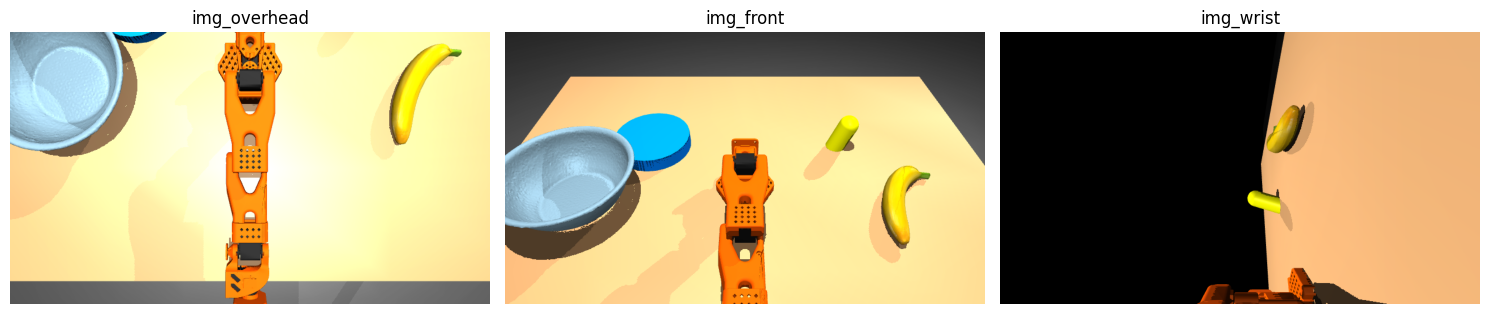

Time: 3.0s | Step: 90


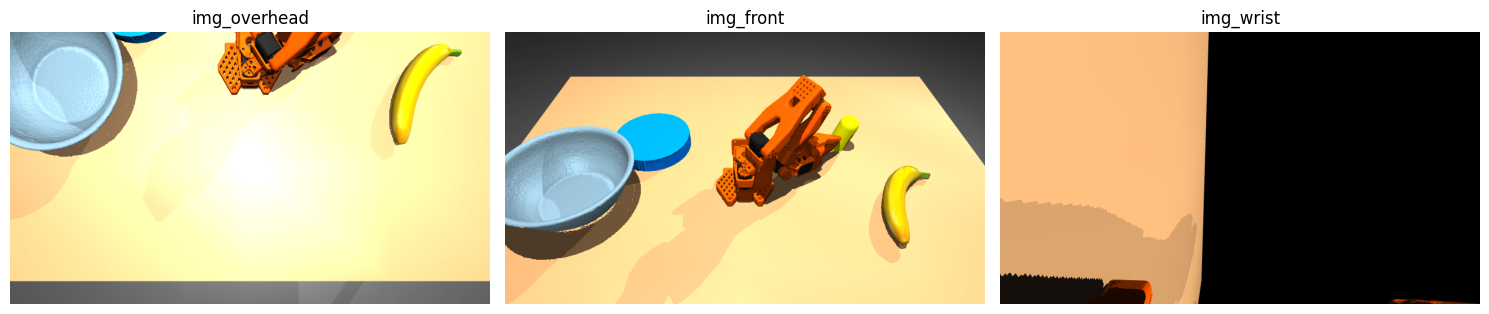

Time: 6.0s | Step: 180


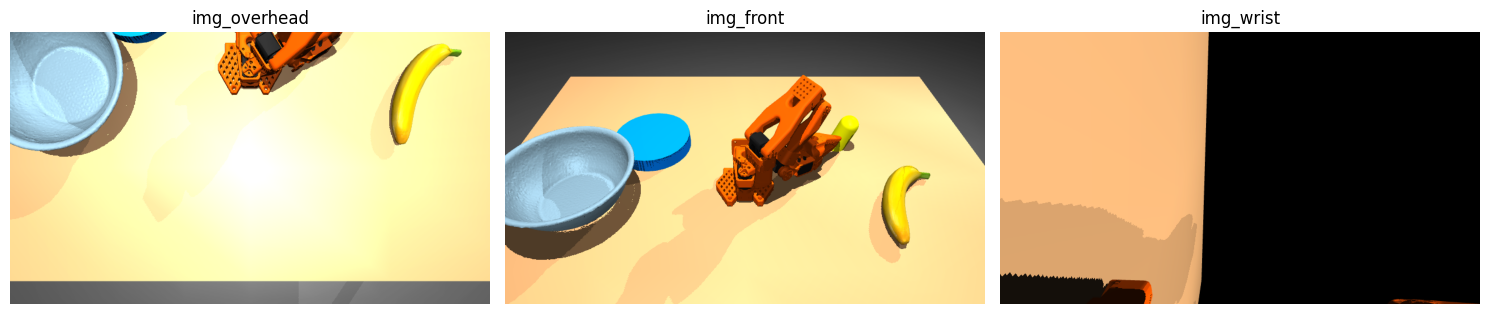

Time: 9.0s | Step: 270


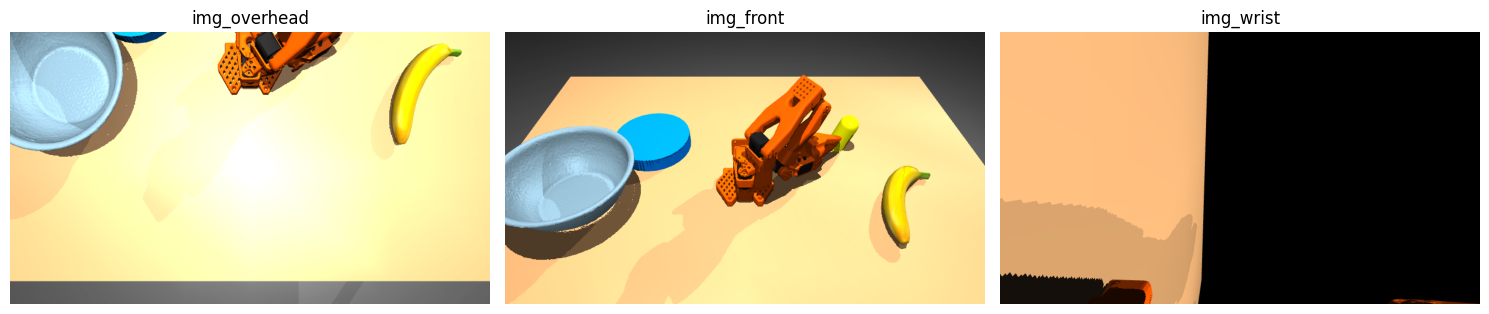

In [22]:
INFERENCE_DURATION = 10.0
FPS = 30
DISPLAY_INTERVAL = 3.0
dt = 1.0 / FPS

policy = MockPolicy()
total_steps = int(INFERENCE_DURATION * FPS)
last_display_time = 0

for step in range(total_steps):
    current_time = step * dt
    action = policy.select_action(observation)
    observation = lerobot.step(action)
    
    if current_time - last_display_time >= DISPLAY_INTERVAL or step == 0:
        print(f"Time: {current_time:.1f}s | Step: {step}")
        plot_images(observation)
        last_display_time = current_time
    
    time.sleep(dt)